# Preparation

### Import, constants and functions

In [ ]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [ ]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [ ]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

In [ ]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [ ]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    4310 samples
Test set:     1437 samples
Sample dims:  (4310, 54, 96, 3)


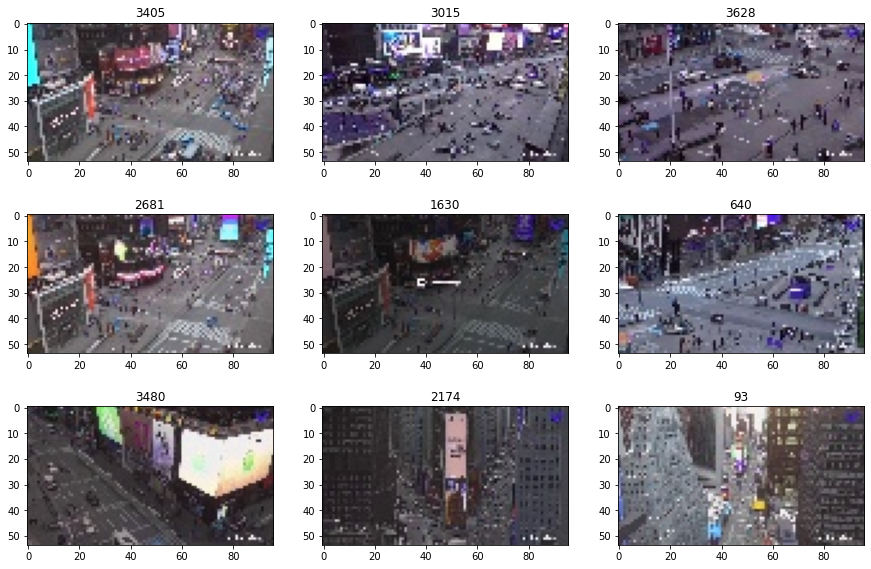

In [ ]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [ ]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [35]:
latent_dim = 1000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([        
        layers.Dense(width*hight*3, activation='sigmoid'),
        layers.Reshape((hight, width, 3)),
        layers.Conv2DTranspose(6, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, kernel_size=(3, 3), activation="relu", padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [36]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [37]:
epochs = 50
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/50
270/270 [==============================] - 85s 241ms/step - loss: 0.0447 - accuracy: 0.4552 - val_loss: 0.0193 - val_accuracy: 0.4895
Epoch 2/50
270/270 [==============================] - 64s 237ms/step - loss: 0.0151 - accuracy: 0.5237 - val_loss: 0.0124 - val_accuracy: 0.5331
Epoch 3/50
270/270 [==============================] - 64s 236ms/step - loss: 0.0114 - accuracy: 0.5399 - val_loss: 0.0100 - val_accuracy: 0.5684
Epoch 4/50
270/270 [==============================] - 64s 238ms/step - loss: 0.0093 - accuracy: 0.5707 - val_loss: 0.0084 - val_accuracy: 0.6034
Epoch 5/50
270/270 [==============================] - 65s 240ms/step - loss: 0.0084 - accuracy: 0.6018 - val_loss: 0.0077 - val_accuracy: 0.5948
Epoch 6/50
270/270 [==============================] - 65s 239ms/step - loss: 0.0080 - accuracy: 0.6293 - val_loss: 0.0089 - val_accuracy: 0.6471
Epoch 7/50
270/270 [==============================] - 64s 238ms/step - loss: 0.0072 - accuracy: 0.6491 - val_loss: 0.0066 - val_ac

Train Acc      0.8077853322029114
Validation Acc 0.8086666464805603


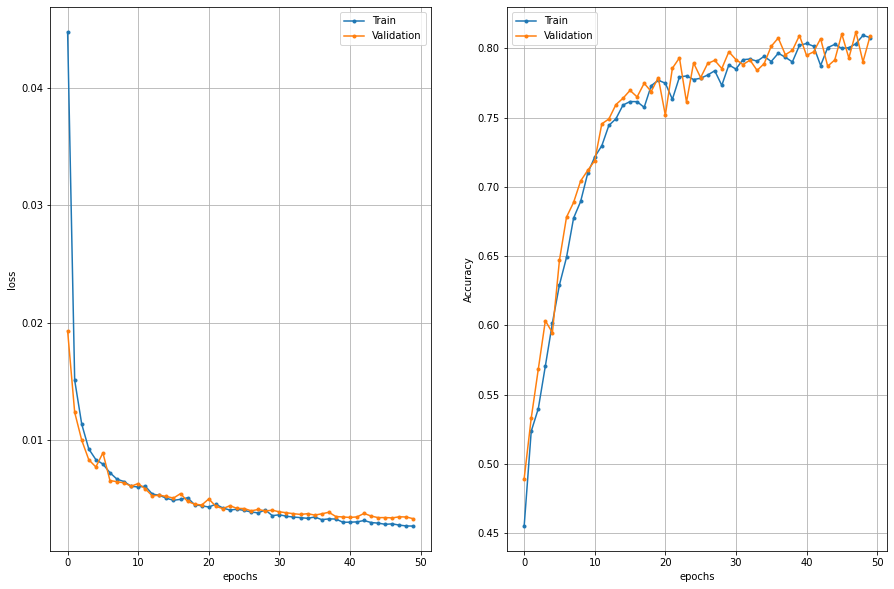

In [38]:
show_results(history)

In [39]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [40]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (1437, 1000)
Sample decoded:  (1437, 54, 96, 3)
comression:  15.552


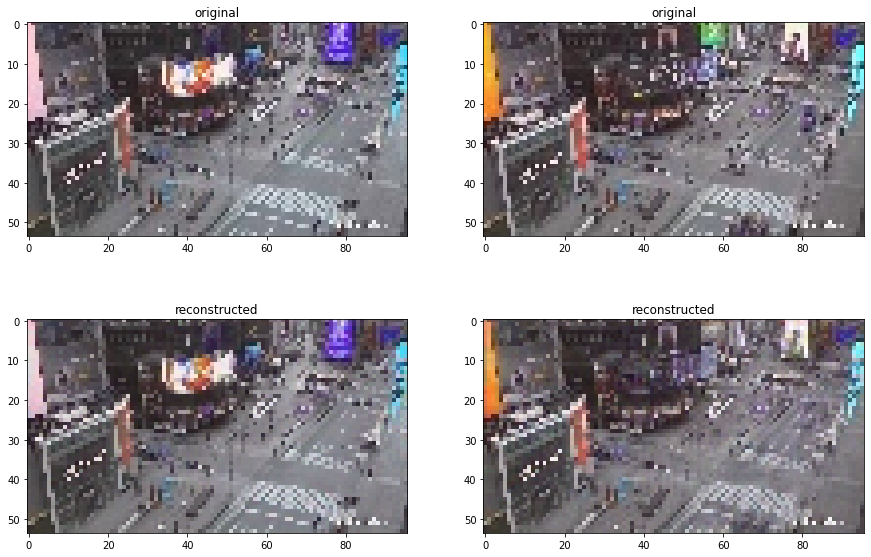

In [41]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

In [42]:
autoencoder.summary()

Model: "autoencoder_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 1000)              9990088   
                                                                 
 sequential_17 (Sequential)  (None, 54, 96, 3)         15567885  
                                                                 
Total params: 25,557,973
Trainable params: 25,557,973
Non-trainable params: 0
_________________________________________________________________


In [43]:
autoencoder.encoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, None, None, 16)    448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, None, None, 16)   0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, None)              0         
                                                                 
 dense_16 (Dense)            (None, 1000)            

In [44]:
autoencoder.decoder.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 15552)             15567552  
                                                                 
 reshape_8 (Reshape)         (None, 54, 96, 3)         0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 54, 96, 6)        168       
 Transpose)                                                      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 54, 96, 6)         0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 54, 96, 3)        165       
 Transpose)                                                      
                                                                 
Total params: 15,567,885
Trainable params: 15,567,885